# 机器学习练习 7 - K-means 和PCA（主成分分析） 

本次练习中，我们将实现K-means聚类，并使用它来压缩图像。 我们将从一个简单的2D数据集开始，以了解K-means是如何工作的，然后我们将其应用于图像压缩。 我们还将对主成分分析进行实验，并了解如何使用它来找到面部图像的低维表示。

## Kmeans 聚类

我们将实施和应用K-means到一个简单的二维数据集，以获得一些直观的工作原理。 K-means是一个迭代的，无监督的聚类算法，将类似的实例组合成簇。 该算法通过随机初始化每个簇的初始聚类中心开始，然后重复将实例分配给最近的簇，并重新计算该簇的聚类中心。 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from  scipy.io import loadmat 


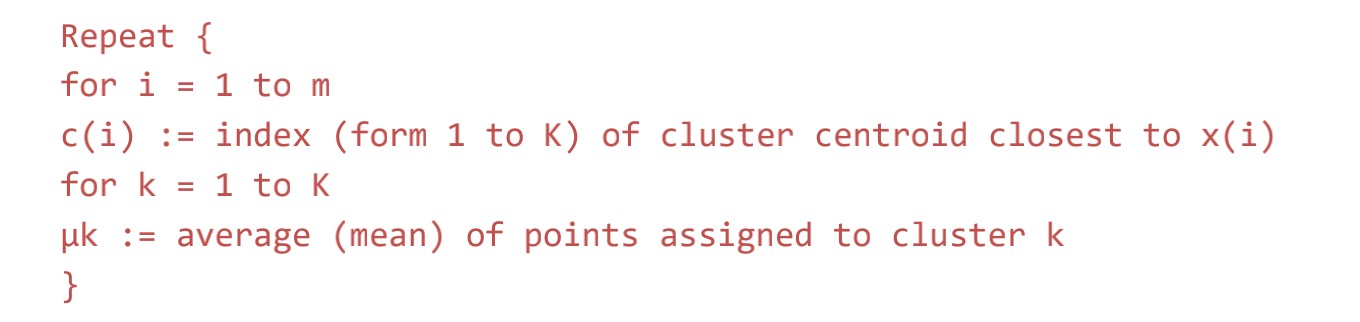

我们要实现的第一部分是找到数据中每个实例最接近的聚类中心的函数。

In [3]:
# 寻找每个实例最近的聚类中心
def find_closest_centroids(X , centroids): 
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m): 
        min_dist = 1000000
        for j in range(k): 
            dist = np.sum( (X[i,:] - centroids[j,:])**2 )
            if dist < min_dist: 
                min_dist = dist
                idx[i] = j
                
    return idx
    

让我们来测试这个函数，以确保它的工作正常。 我们将使用练习中提供的测试用例。

In [4]:
data = loadmat('data/ex7data2.mat')
X = data['X']
initial_centroids = np.array( [ [3,3], [6,2], [8,5] ] )
idx = find_closest_centroids(X , initial_centroids)
idx[0:3]

array([0., 2., 1.])

这里虽然是三个聚类中心 ， 但是在idx中对应的值是0,1,2 .(从0开始)

查看一下数据集

In [5]:
data2 = pd.DataFrame( data.get('X') , columns= ['X1','X2'] )
data2.head()



,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


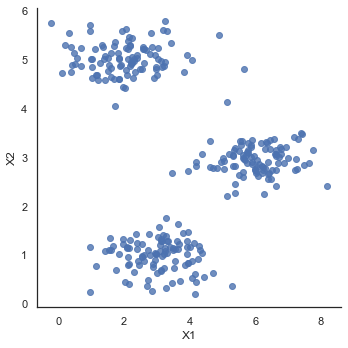

In [6]:
sb.set( context='notebook' , style='white' )
sb.lmplot( 'X1' , 'X2' , data=data2 , fit_reg=False )
plt.show()


接下来，我们需要一个函数来计算簇的新的聚类中心。 聚类中心只是当前分配给簇的所有样本的平均值。

In [7]:
def compute_centroids(X , idx , k): 
    m , n = X.shape
    centroids = np.zeros( (k,n) )
    
    for i in range(k): 
        
        indices = np.where(idx == i)
        centroids[i,:] = ( np.sum(  X[indices,:] , axis=1 )/len(indices[0]) ).ravel()

    
    return centroids
      

In [8]:
compute_centroids(X , idx , 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

现在我们有分配实例的函数，也有计算聚类中心的函数，现在我们将其组合起来，构建一个简单的Kmeans算法

In [9]:
def run_k_means(X , initial_centroids , max_iters): 
    m , n = X.shape
    k = initial_centroids.shape[0]
    ids = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters): 
        idx = find_closest_centroids(X , centroids)# 分配
        centroids = compute_centroids(X , idx , k)# 计算
    
    return idx , centroids
    

In [10]:
idx , centroids = run_k_means(X , initial_centroids , 10)

可视化分类结果

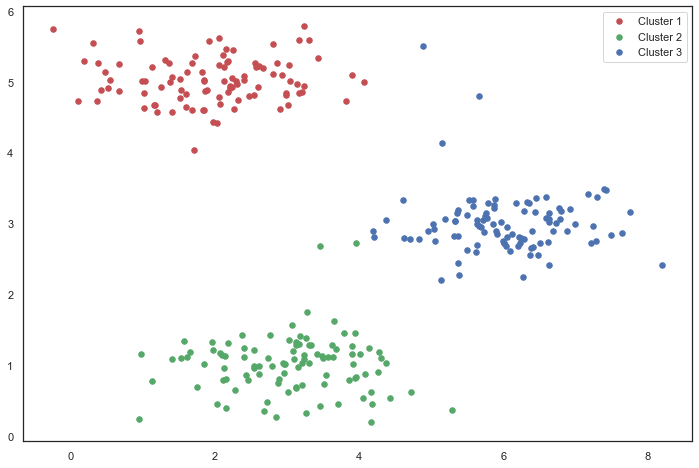

In [11]:
cluster1 = X[ np.where(idx == 0)[0],: ]
cluster2 = X[ np.where(idx == 1)[0],: ]
cluster3 = X[ np.where(idx == 2)[0],: ]

fig , ax = plt.subplots( figsize=(12,8) )

ax.scatter(cluster1[:,0] , cluster1[:,1] , s=30 , color='r' , label = 'Cluster 1'  )
ax.scatter(cluster2[:,0] , cluster2[:,1] , s=30 , color='g' , label = 'Cluster 2'  )
ax.scatter(cluster3[:,0] , cluster3[:,1] , s=30 , color='b' , label = 'Cluster 3'  )

ax.legend()
plt.show()




刚才我们跳过的一个步骤是初始化聚类中心的过程。 这可能会影响算法的收敛。 现在,我们创建一个选择随机样本并将其用作初始聚类中心的函数。

In [12]:
def init_centroids(X,k):
    m , n = X.shape
    centroids = np.zeros( (k,n) )
    idx = np.random.randint( 0,m,k )
    
    for i in range(k): 
        centroids[i,:] = X[idx[i],:]
        
        
    return centroids
        

In [13]:
init_centroids(X,3)

array([[5.37293912, 2.81684776],
       [3.2645514 , 1.3836869 ],
       [7.65503226, 2.87095628]])

我们的下一个任务是将K-means应用于图像压缩。 下面，我们可以使用聚类来找到最具代表性的少数颜色，并使用聚类分配将原始的24位颜色映射到较低维的颜色空间。 



先展示一下我们要压缩的图片

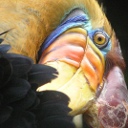

In [14]:
from IPython.display import Image
Image(filename='data/bird_small.png')

读取并查看一下原始像素测像素点数值

In [15]:
image_data = loadmat('data/bird_small.mat')
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [16]:
A = image_data['A']
A.shape

(128, 128, 3)

现在我们需要对数据进行一些预处理，并将其提供给K-means算法。

In [17]:
A = A/255 # 数据预处理，归一化


# reshape the array
X = np.reshape(A , ( A.shape[0] * A.shape[1] , A.shape[2] ) )
X.shape


(16384, 3)

In [18]:
# 随机初始化聚类中心
initial_centroids = init_centroids(X , 16)

# 运行算法 
idx , centroids = run_k_means(X , initial_centroids , 10)

# 获得分类结果
idx = find_closest_centroids(X , centroids)

# 通过结果压缩数据
X_recovered = centroids[ idx.astype(int) , : ]
X_recovered.shape


(16384, 3)

In [19]:
# 还原维度
X_recovered = np.reshape(X_recovered , (A.shape[0] , A.shape[1] , A.shape[2]))
X_recovered.shape

(128, 128, 3)

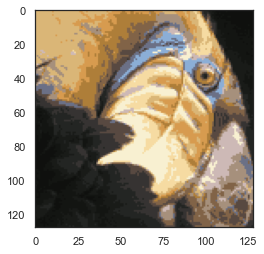

In [20]:
plt.imshow(X_recovered)
plt.show()

可以看到我们对图像进行了压缩，但图像的主要特征仍然存在。 这就是K-means在图像压缩方面的应用。   
下面我们直接用scikit-learn来实现K-means。

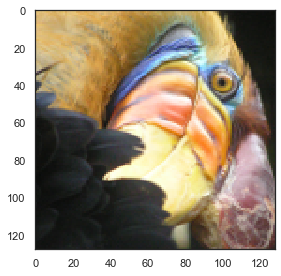

In [21]:
from  skimage import io

# 需要预处理数据
pic = io.imread('data/bird_small.png')/255
io.imshow(pic)
plt.show()

In [22]:
pic.shape

(128, 128, 3)

In [23]:
# 序列化数据
data = pic.reshape(128*128,3)

In [24]:
data.shape

(16384, 3)

In [25]:
from sklearn.cluster import KMeans
model = KMeans( n_clusters=16 , n_init=100 , n_jobs=-1 )


In [26]:
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [27]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [28]:
centroids[C].shape

(16384, 3)

In [29]:
compressed_pic = centroids[C].reshape( (128,128,3) )


前后对比

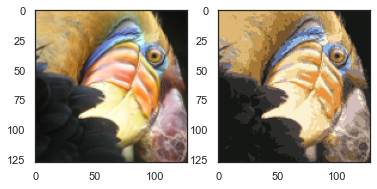

In [30]:
fig , ax = plt.subplots( 1,2 )
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## Principal component analysis（主成分分析）

PCA是在数据集中找到“主成分”或最大方差方向的线性变换。 它可以用于降维。 在本练习中，我们首先实现PCA并将其应用于一个简单的二维数据集，了解它是如何工作的。

先附上PCA课上讲到的的相关公式及求解步骤(图片来自黄博整理的笔记)

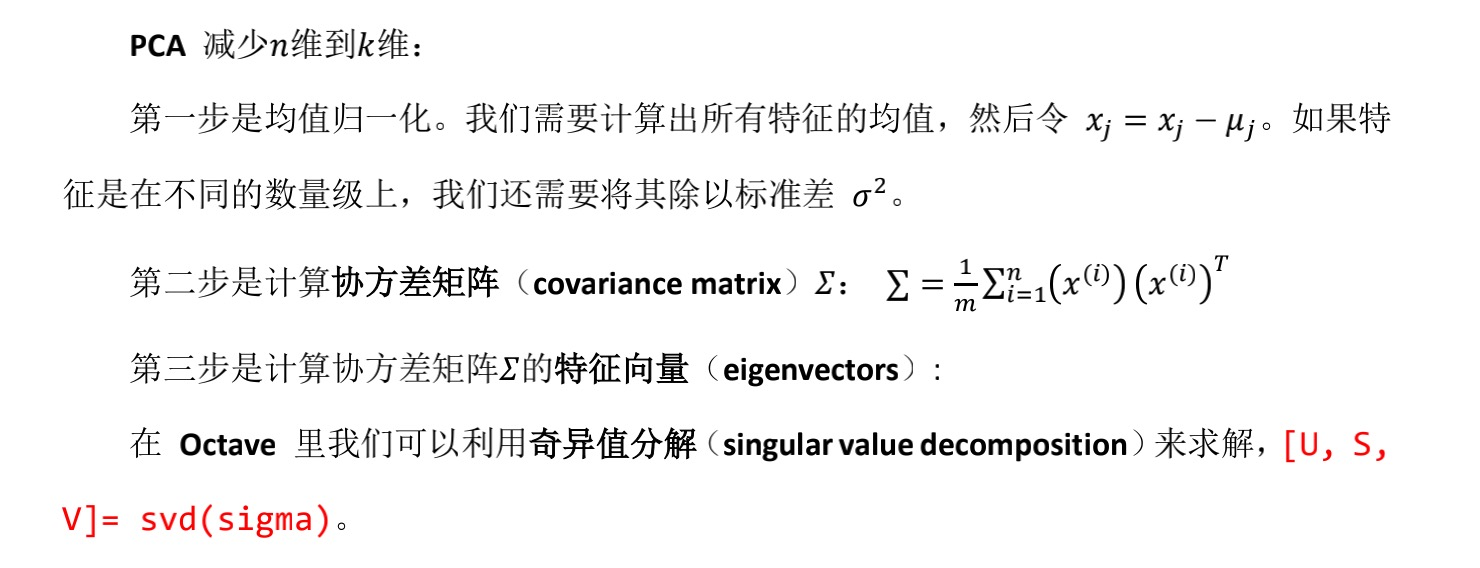


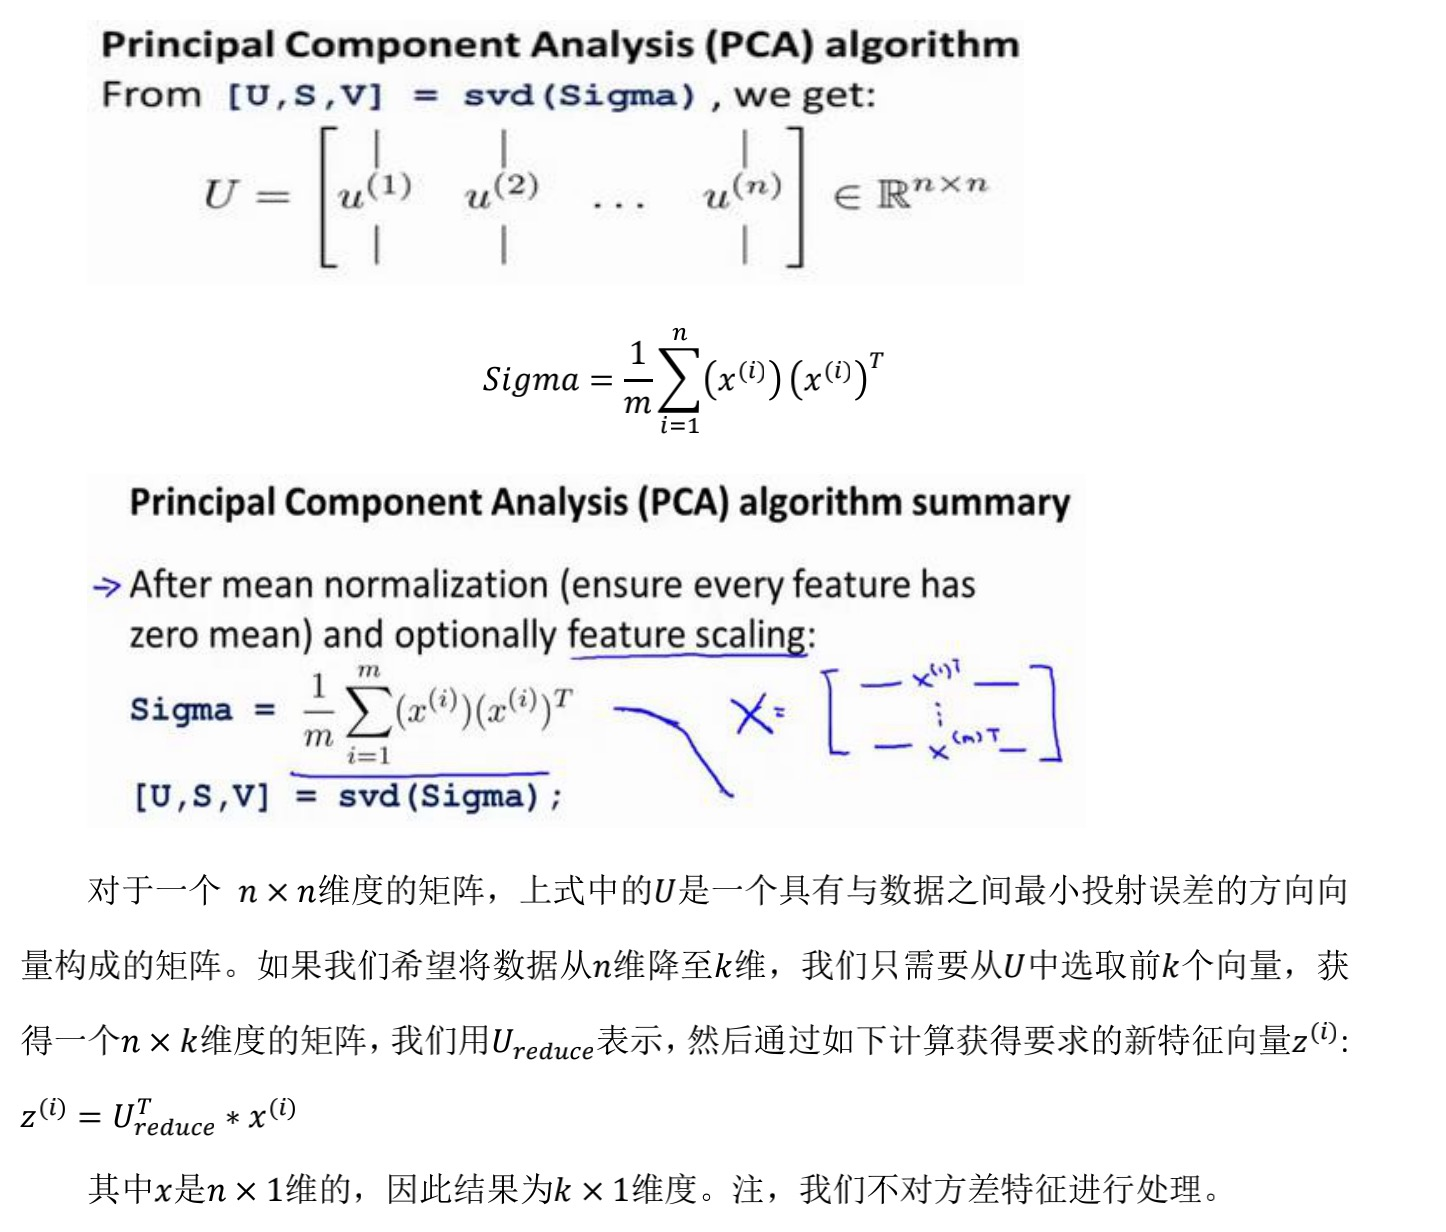

另外： 还原的公式是：   
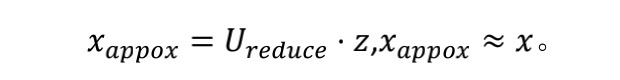

建议 对于上面的降维公式，以及还原公式，在纸上画一画维度的变化

加载并可视化数据集

In [31]:
data = loadmat('data/ex7data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 14 22:41:44 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[3.38156267, 3.38911268],
        [4.52787538, 5.8541781 ],
        [2.65568187, 4.41199472],
        [2.76523467, 3.71541365],
        [2.84656011, 4.17550645],
        [3.89067196, 6.48838087],
        [3.47580524, 3.63284876],
        [5.91129845, 6.68076853],
        [3.92889397, 5.09844661],
        [4.56183537, 5.62329929],
        [4.57407171, 5.39765069],
        [4.37173356, 5.46116549],
        [4.19169388, 4.95469359],
        [5.24408518, 4.66148767],
        [2.8358402 , 3.76801716],
        [5.63526969, 6.31211438],
        [4.68632968, 5.6652411 ],
        [2.85051337, 4.62645627],
        [5.1101573 , 7.36319662],
        [5.18256377, 4.64650909],
        [5.70732809, 6.68103995],
        [3.57968458, 4.80278074],
        [5.63937773, 6.12043594],
        [4.26346851, 4.68942896],
        [2.53651693, 3.88449078],
      

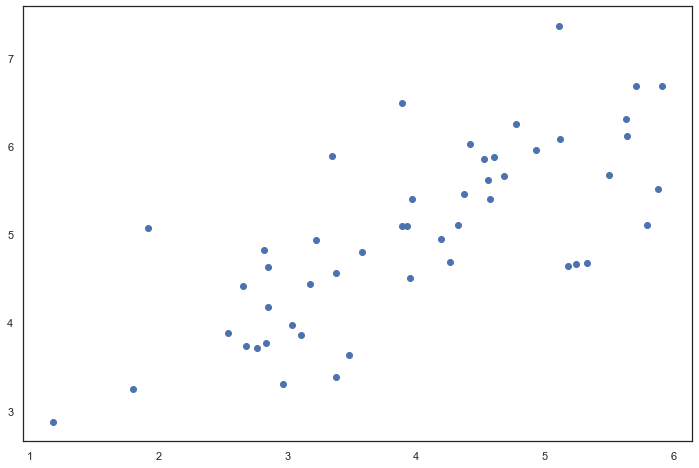

In [32]:
X = data['X']

fig , ax  = plt.subplots( figsize = (12,8) )
ax.scatter(X[:,0] , X[:,1])
plt.show()


PCA的算法相当简单。 在确保数据被归一化之后，输出仅仅是原始数据的协方差矩阵的奇异值分解。

就像课上说的，我们使用svd函数，直接获取相关矩阵

In [33]:
def pca(X): 
    
    #  归一化数据
    X = ( X - X.mean() ) / X.std()
    
    # 计算协方差矩阵
    X = np.matrix(X)
    cov = (X.T * X)/(X.shape[0])
    
    # 运行SVD函数获取参数
    U , S , V = np.linalg.svd(cov)
    
    return U , S , V
    

In [34]:
U , S , V = pca(X)
U , S , V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([1.43584536, 0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

现在我们有主成分（矩阵U），我们可以用这些来将原始数据投影到一个较低维的空间中。 对于这个任务，我们将实现一个计算投影并且仅选择顶部K个分量的函数，有效地减少了维数。  
即： 给出降维程度，计算降维后的数据

In [35]:
def project_data(X , U , k): 
    
    U_reduced = U[:,:k]
    return np.dot( X , U_reduced )
    

In [36]:
Z = project_data(X , U , 1)
Z

matrix([[-4.74689738],
        [-7.15889408],
        [-4.79563345],
        [-4.45754509],
        [-4.80263579],
        [-7.04081342],
        [-4.97025076],
        [-8.75934561],
        [-6.2232703 ],
        [-7.04497331],
        [-6.91702866],
        [-6.79543508],
        [-6.3438312 ],
        [-6.99891495],
        [-4.54558119],
        [-8.31574426],
        [-7.16920841],
        [-5.08083842],
        [-8.54077427],
        [-6.94102769],
        [-8.5978815 ],
        [-5.76620067],
        [-8.2020797 ],
        [-6.23890078],
        [-4.37943868],
        [-5.56947441],
        [-7.53865023],
        [-7.70645413],
        [-5.17158343],
        [-6.19268884],
        [-6.24385246],
        [-8.02715303],
        [-4.81235176],
        [-7.07993347],
        [-5.45953289],
        [-7.60014707],
        [-4.39612191],
        [-7.82288033],
        [-3.40498213],
        [-6.54290343],
        [-7.17879573],
        [-5.22572421],
        [-4.83081168],
        [-7

我们也可以通过反向转换步骤来恢复原始数据。

In [37]:
def recover_data(Z , U , k): 
    
    U_reduced = U[:,:k]
    return np.dot(Z , U_reduced.T)
    

In [38]:
X_recovered = recover_data(Z , U , 1)
X_recovered

matrix([[3.76152442, 2.89550838],
        [5.67283275, 4.36677606],
        [3.80014373, 2.92523637],
        [3.53223661, 2.71900952],
        [3.80569251, 2.92950765],
        [5.57926356, 4.29474931],
        [3.93851354, 3.03174929],
        [6.94105849, 5.3430181 ],
        [4.93142811, 3.79606507],
        [5.58255993, 4.29728676],
        [5.48117436, 4.21924319],
        [5.38482148, 4.14507365],
        [5.02696267, 3.8696047 ],
        [5.54606249, 4.26919213],
        [3.60199795, 2.77270971],
        [6.58954104, 5.07243054],
        [5.681006  , 4.37306758],
        [4.02614513, 3.09920545],
        [6.76785875, 5.20969415],
        [5.50019161, 4.2338821 ],
        [6.81311151, 5.24452836],
        [4.56923815, 3.51726213],
        [6.49947125, 5.00309752],
        [4.94381398, 3.80559934],
        [3.47034372, 2.67136624],
        [4.41334883, 3.39726321],
        [5.97375815, 4.59841938],
        [6.10672889, 4.70077626],
        [4.09805306, 3.15455801],
        [4.907

可视化还原后的数据

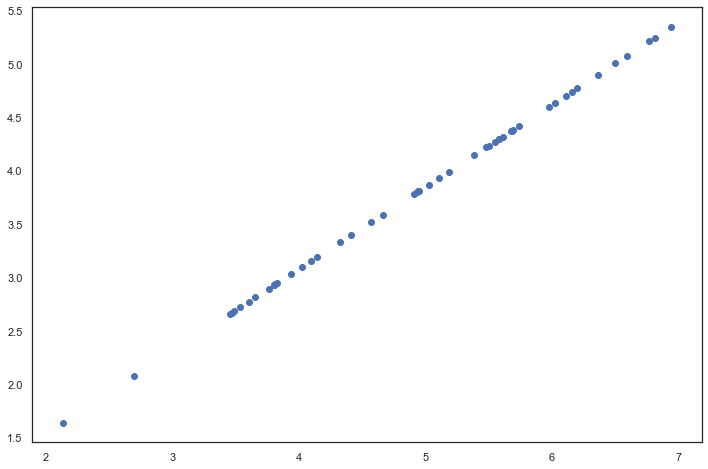

In [39]:
fig , ax = plt.subplots( figsize=(12,8) )
ax.scatter( list(X_recovered[:,0]) , list(X_recovered[:,1]) )
plt.show()


请注意，第一主成分的投影轴基本上是数据集中的对角线。 当我们将数据减少到一个维度时，我们失去了该对角线周围的变化，所以在我们的再现中，一切都沿着该对角线。  


我们在此练习中的最后一个任务是将PCA应用于脸部图像。 通过使用相同的降维技术，我们可以使用比原始图像少得多的数据来捕获图像的“本质”。

In [40]:
face = loadmat('data/ex7faces.mat')
X = face['X']
X.shape

(5000, 1024)

In [41]:
# 函数功能： 绘制前n个图形 
def plot_n_image(X , n): 
    
    pic_size = int( np.sqrt(X.shape[1]) )
    grid_size = int( np.sqrt(n) )
    
    first_n_images = X[:n,:]
    
    fig , ax_array = plt.subplots( nrows=grid_size , ncols=grid_size,
                                 sharey= True , sharex = True , figsize=(8,8)
                                 )
    
    
    for r in range(grid_size): 
        for c in range(grid_size): 
            ax_array[r,c].imshow( first_n_images[grid_size*r+c].reshape( (pic_size , pic_size) ) )
            plt.xticks( np.array([]) )
            plt.yticks( np.array([]) )
        
        
    
    

形象的看一下数据集

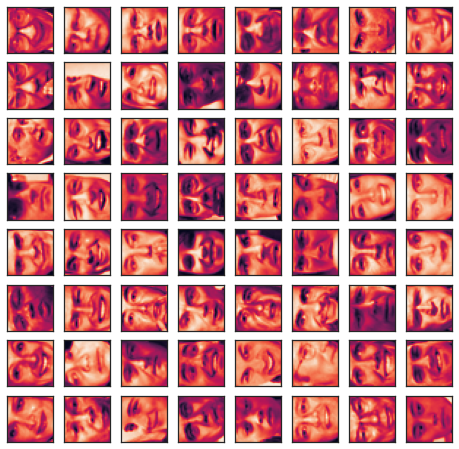

In [42]:
plot_n_image(X,64)

我们选择其中的一个来利用PCA进行压缩

压缩前

In [43]:
face = np.reshape( X[3,:] , (32,32) )

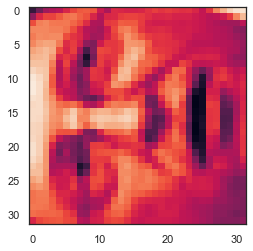

In [44]:
plt.imshow(face)
plt.show()


In [45]:
U , S , V = pca(X)
Z = project_data(X , U , 100)

现在我们可以尝试恢复原来的结构并再次渲染。   
压缩得到的图片： 


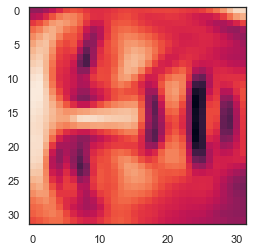

In [46]:
X_recovered = recover_data(Z , U , 100)
face = np.reshape( X_recovered[3,:] , (32,32) )
plt.imshow(face)
plt.show()

请注意，我们失去了一些细节，尽管没有像您预期的维度数量减少10倍。

最后练习7.在最后的练习中，我们将实现异常检测算法，并使用协同过滤构建推荐系统。
